# Case Study for Image Classification

## Data Overview

Sample data consists of 1000 images split evenly accross 10 classes of identity documents. The classes are as follows, 

Albanian Identity Card - alb_id  Azerbaijan Passport - aze_passport  
Spanish ID -  esp_id  
Estonian ID - est_id  
Finish ID - fin_id  
Greek Passport - grc_passport  
Latvian Passport - lva_passport  
Russian Passport - rus_internalpassport  
Serbian Passport - srb_passport  
Slovak ID - svk_id  

Documents present in this sample are of varying quality. A few contain glare and blur which obstruct key text features on the documents. Some of them are set against backgrounds which introduce noise and clutter to the image.

## Problem Statement

The problem statement of this case study is to develop a classification model to accurately classify the identity document types into their respective classes.

## Working Directory Structure

The Working directory is structured in the following manner

|---- datasets  
|---- models  
|---- csv  
|---- \<python files\>


In [1]:
# Importing Dependecies

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim, Tensor
from PIL import Image
import glob 
import numpy as np
import os 
import shutil 
import tqdm
import gc
import re
import pandas as pd
import pickle
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve

### Sampling
The Following block of code splits the raw data into 3 sets for training, validating and testing with 50\:25\:25 images each respectively.

|---- datasets  
|--------| baseline  
|--------|----| train  
|--------|----|----| images  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| aze_passport  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  
|--------|----|----| labels  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----| aze_passport  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  
|--------|----| val  
|--------|----|----| images  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| aze_passport  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  
|--------|----|----| labels  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----| aze_passport  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  
|--------|----| test  
|--------|----|----| images  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| aze_passport  
|--------|----|----|----|----| 00.jpg  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  
|--------|----|----| labels  
|--------|----|----|----| alb_id  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----| aze_passport  
|--------|----|----|----|----| 00.txt  
|--------|----|----|----|----| ...  
|--------|----|----|----| ...  

In [2]:
def random_sample(source_path,dataset_path):
    source = glob.glob(f'{source_path}/*')
    
    labels_dict = {
        'alb_id':0,
        'aze_passport':1,
        'esp_id':2,
        'est_id':3,
        'fin_id':4,
        'grc_passport':5,
        'lva_passport':6,
        'rus_internalpassport':7,
        'srb_passport':8,
        'svk_id':9,
    }
    dataset = dataset_path
    for classes in source:
        images = glob.glob(classes + '/*')
        label = labels_dict[os.path.basename(classes)]
        rnd = np.random.choice(images, 50, replace=False)
        print(classes)
        # print(f'train images: {len(rnd)}')
        os.makedirs(f'./train/{os.path.basename(classes)}', exist_ok=True)
        for r in rnd:
            if not os.path.exists(f'./{dataset}/train/{os.path.basename(classes)}/images'):
                os.makedirs(f'./{dataset}/train/{os.path.basename(classes)}/images')
            if not os.path.exists(f'./{dataset}/train/{os.path.basename(classes)}/labels'):
                os.makedirs(f'./{dataset}/train/{os.path.basename(classes)}/labels')
            shutil.copy(r, f'./{dataset}/train/{os.path.basename(classes)}/images/{os.path.basename(r)}')
            with open(f'./{dataset}/train/{os.path.basename(classes)}/labels/{os.path.basename(r).split(".")[0]}.txt', 'w') as file:
                file.write(str(label))
    
        remaining_images = list(set(images) - set(rnd))
        rnd = np.random.choice(remaining_images, 25, replace=False)
        # print(f'val images: {len(rnd)}')
        for r in rnd:
            if not os.path.exists(f'./{dataset}/val/{os.path.basename(classes)}/images'):
                os.makedirs(f'./{dataset}/val/{os.path.basename(classes)}/images')
            if not os.path.exists(f'./{dataset}/val/{os.path.basename(classes)}/labels'):
                os.makedirs(f'./{dataset}/val/{os.path.basename(classes)}/labels')
            shutil.copy(r, f'./{dataset}/val/{os.path.basename(classes)}/images/{os.path.basename(r)}')
            with open(f'./{dataset}/val/{os.path.basename(classes)}/labels/{os.path.basename(r).split(".")[0]}.txt', 'w') as file:
                file.write(str(label))
        
        remaining_images = list(set(remaining_images) - set(rnd))
        rnd = remaining_images
        # print(f'test images: {len(rnd)}')
        for r in rnd:
            if not os.path.exists(f'./{dataset}/test/{os.path.basename(classes)}/images'):
                os.makedirs(f'./{dataset}/test/{os.path.basename(classes)}/images')
            if not os.path.exists(f'./{dataset}/test/{os.path.basename(classes)}/labels'):
                os.makedirs(f'./{dataset}/test/{os.path.basename(classes)}/labels')
            shutil.copy(r, f'./{dataset}/test/{os.path.basename(classes)}/images/{os.path.basename(r)}')
            with open(f'./{dataset}/test/{os.path.basename(classes)}/labels/{os.path.basename(r).split(".")[0]}.txt', 'w') as file:
                file.write(str(label))

random_sample('./datasets/images', 'datasets/baseline')

./datasets/images\alb_id
./datasets/images\aze_passport
./datasets/images\esp_id
./datasets/images\est_id
./datasets/images\fin_id
./datasets/images\grc_passport
./datasets/images\lva_passport
./datasets/images\rus_internalpassport
./datasets/images\srb_passport
./datasets/images\svk_id


### Data Labelling

For baseline dataset,
* Data is split between training, validation and test sets.
* `images` and `label` subfolders contain images and labels to be used respectively.
* Each subfolder in images corresponds to one class.
* For every image in a class, a corresponding txt file containing the label is present in the labels folder.

#### Sample Image in the dataset

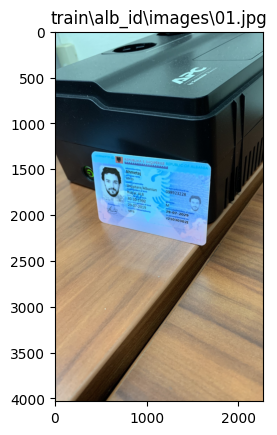

In [3]:
train_image = glob.glob('datasets\\baseline\\train\\alb_id\\images\\*.jpg')[0]
image = cv2.imread(train_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title('train\\alb_id\\images\\01.jpg')
plt.imshow(image)
plt.show()

#### Sample label in the dataset

Corresponding label for this image is 

train\alb_id\labels\01.txt

In [4]:
train_label = glob.glob('datasets\\baseline\\train\\alb_id\\labels\\*.txt')[0]
with open(train_label, 'r') as file:
    print(file.read())

0


## Convolution Neural Network Model

A CNN model operates by detecting features in an image. It would be ideal in this scenario to classify these identity cards. 

The following is a basic CNN model using the torch framework. It contains,
2 Convolution layers to detect features.  
1 Max pooling layer to reduce dimensionality of the convolution layers.  
3 Dropout layers to reduce overfitting.  
5 Relu activation layers.  
1 Flatten layer.  
4 Fully connected layers.  
1 LogSoftMax activation layers to provide an interpretable output.  


In [5]:
class ConvolutionModel(nn.Module):
    def __init__(self, input_width=640, input_height=480, num_classes=10, is_bw=False):
        super().__init__()
        channels = 1 if is_bw else 3
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(32*int((input_width/2)*(input_height/2)), 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 128)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(128, 64)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(64, num_classes)
        self.act6 = nn.LogSoftmax(dim=1)
 
    def forward(self, x):
        # input 3x640x480, output 32x640x480
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        
        # input 32x640x480, output 32x640x480
        x = self.act2(self.conv2(x))
        
        # input 32x640x480, output 3x640x480
        x = self.pool2(x)
        
        # input 32x320x240, output 2457600
        x = self.flat(x)
        
        # input 2457600, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)

        # input 512, output 128
        x = self.act4(self.fc4(x))
        # x = self.drop4(x)

        # input 128, output 64
        x = self.act5(self.fc5(x))
        x = self.drop5(x)

        # input 64, output 10
        x = self.act6(self.fc6(x))
        return x

### Data Loaders
The following data loader simplifies the process of loading and preprocessing image and label data. 
For images the data loader,
* Reads image from source
* Resizes the images to 640*480
* Converts the image to greyscale (optional)
* Converts the Image to a tensor

For labels the data loader,
* Reads the label from source
* Converts it into and array
* Converts the array into a tensor

In [6]:
class ImageDataset(Dataset):
    def __init__(self, dir, width, height, is_bw=False):
        self.dir = dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((width, height)),
            transforms.ToTensor()
        ]) if is_bw else transforms.Compose([
            transforms.Resize((width, height)),
            transforms.ToTensor()
        ])
        self.target_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
        self.imageNames = glob.glob(f'{dir}/*/images/*.jpg') # Find all images in directory
        self.labelNames = glob.glob(f'{dir}/*/labels/*.txt') # find all labels in directory
    
    def __len__(self):
        return len(self.imageNames)
    
    def __getitem__(self, index):
        image = Image.open(self.imageNames[index])
        with open(self.labelNames[index], 'r') as file:
            label = file.read()
            label = np.array(label)
        
        return self.transform(image), int(label)

## Baseline Classification

A baseline classification run will be conducted using the above data loaders and convolution model. This run is performed without any feature engineering to understand how a raw model performs on source data. 

Running underlying python files since Jupyter Notebook caches variables causing a out of memory error.

Note: The below cell takes ~40 mins to train (RTX3060)

In [7]:
!python train_baseline.py

Epoch 0: model accuracy 13.20%
Epoch 1: model accuracy 12.00%
Epoch 2: model accuracy 13.20%
Epoch 3: model accuracy 10.00%
Epoch 4: model accuracy 10.40%
Epoch 5: model accuracy 7.60%
Epoch 6: model accuracy 10.00%
Epoch 7: model accuracy 11.20%
Epoch 8: model accuracy 10.80%
Epoch 9: model accuracy 9.20%
Epoch 10: model accuracy 15.20%
Epoch 11: model accuracy 11.20%
Epoch 12: model accuracy 13.20%
Epoch 13: model accuracy 18.80%
Epoch 14: model accuracy 15.60%
Epoch 15: model accuracy 20.80%
Epoch 16: model accuracy 19.20%
Epoch 17: model accuracy 17.60%
Epoch 18: model accuracy 20.80%
Epoch 19: model accuracy 22.40%



Epoch 0: 100%|##########| 100/100 [02:15<00:00,  1.35s/it]

Validating: 100%|##########| 50/50 [00:25<00:00,  1.94it/s]

Epoch 1: 100%|##########| 100/100 [02:50<00:00,  1.70s/it]

Validating: 100%|##########| 50/50 [00:25<00:00,  1.99it/s]

Epoch 2: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:25<00:00,  1.99it/s]

Epoch 3: 100%|##########| 100/100 [02:50<00:00,  1.70s/it]

Validating: 100%|##########| 50/50 [00:25<00:00,  1.97it/s]

Epoch 4: 100%|##########| 100/100 [02:51<00:00,  1.72s/it]

Validating: 100%|##########| 50/50 [00:24<00:00,  2.01it/s]

Epoch 5: 100%|##########| 100/100 [02:51<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:23<00:00,  2.11it/s]

Epoch 6: 100%|##########| 100/100 [02:51<00:00,  1.72s/it]

Validating: 100%|##########| 50/50 [00:23<00:00,  2.10it/s]

Epoch 7: 100%|##########| 100/100 [02:51<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:23<00:00,  2.08it/s]

Epoch 8: 100%|##########| 100/1

Testing the trained model on test data

In [8]:
!python test_model.py --model_path="models/baseline_best_model.pth" --data_path="datasets/baseline"

Model accuracy 21.20%


### Baseline Results
The baseline model has an accuracy of 21.20%

## Improvements
The dataset contains a lot of clutter. Majority of the documents are not in focus or they form a small percentage of the overall image. A few examples of this are given below.

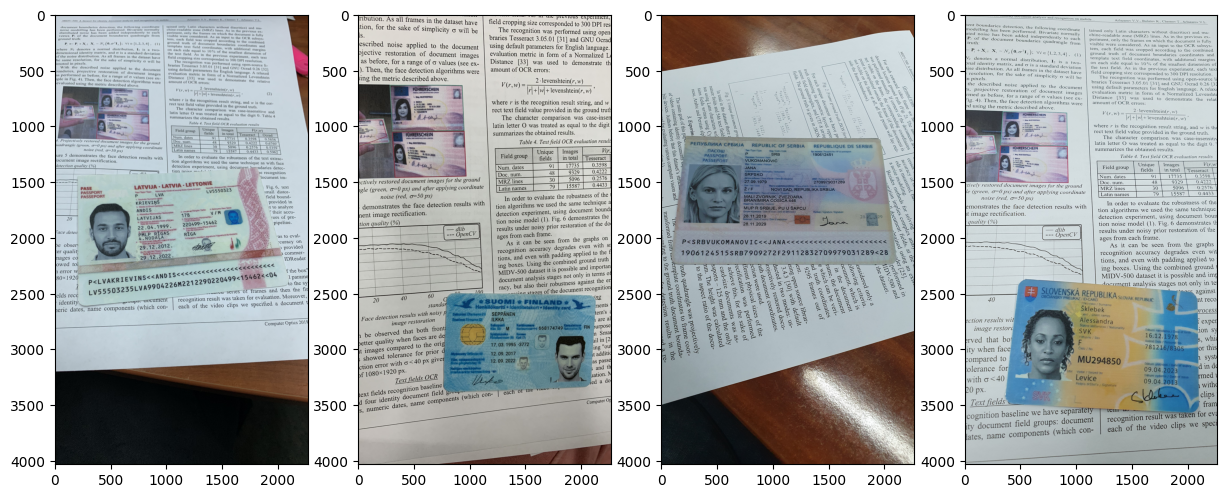

In [9]:
lva_pass = cv2.imread('datasets/images/lva_passport/24.jpg')
lva_pass = cv2.cvtColor(lva_pass, cv2.COLOR_BGR2RGB)
fin_id = cv2.imread('datasets/images/fin_id/22.jpg')
fin_id = cv2.cvtColor(fin_id, cv2.COLOR_BGR2RGB)
arb_pass = cv2.imread('datasets/images/srb_passport/28.jpg')
arb_pass = cv2.cvtColor(arb_pass, cv2.COLOR_BGR2RGB)
svk_id = cv2.imread('datasets/images/svk_id/27.jpg')
svk_id = cv2.cvtColor(svk_id, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15,10))
cols = 4

fig.add_subplot(1, cols, 1)
plt.imshow(lva_pass)
fig.add_subplot(1, cols, 2)
plt.imshow(fin_id)
fig.add_subplot(1, cols, 3)
plt.imshow(arb_pass)
fig.add_subplot(1, cols, 4)
plt.imshow(svk_id)
plt.show()

An object detection model should be implemented to reduce background noise and clutter. This model should be trained on "card" type objects and run over the sample data. The output will locate the identity document in the overall photo. This can then be cropped and used for classification.

### YOLOv8
YOLOv8 is one of the state of the art object detectors. It has shown solid performance on various public datasets such as COCO. In this usecase, a pretrained version of YOLOv8 will be retrained on our sample dataset with the objetive of detecting cards. 

#### Labelling
Labelling for the purpose of retraining has been done using an open-source tool named [Label Studio](https://labelstud.io/). The output of this labelling task is stored under `datasets/card`.

#### Training Setup
As per [documentation](https://docs.ultralytics.com/modes/train/) provided by ultralytics for retraining YOLO models. A YML file is created specifying the classes to be trained and dataset location. This file is stored as `card.yml`

In [10]:
!type card.yml

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ./card  # dataset root dir
train: train  # train images (relative to 'path') 4 images
val: val  # val images (relative to 'path') 4 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: card


#### Training Data Folder
|---- datasets
|--------| card  
|--------|----| train  
|--------|----|----| images  
|--------|----|----|----| alb_id_00.jpg  
|--------|----|----|----| alb_id_01.jpg  
|--------|----|----|----| ...  
|--------|----|----| labels  
|--------|----|----|----| alb_id_00.txt  
|--------|----|----|----| alb_id_01.txt  
|--------|----|----|----| ...  
|--------|----| val  
|--------|----|----| images  
|--------|----|----|----| alb_id_00.jpg  
|--------|----|----|----| alb_id_01.jpg  
|--------|----|----|----| ...  
|--------|----|----| labels  
|--------|----|----|----| alb_id_00.txt  
|--------|----|----|----| alb_id_01.txt  
|--------|----|----|----| ...

#### Training YOLOv8

In [11]:
!python train_card.py


  0%|          | 0.00/6.73M [00:00<?, ?B/s]
  9%|9         | 648k/6.73M [00:00<00:00, 6.50MB/s]
 19%|#9        | 1.29M/6.73M [00:00<00:00, 6.63MB/s]
 29%|##8       | 1.93M/6.73M [00:00<00:00, 6.64MB/s]
 38%|###8      | 2.59M/6.73M [00:00<00:00, 6.69MB/s]
 48%|####7     | 3.23M/6.73M [00:00<00:00, 6.68MB/s]
 57%|#####7    | 3.87M/6.73M [00:00<00:00, 6.69MB/s]
 67%|######7   | 4.51M/6.73M [00:00<00:00, 6.69MB/s]
 77%|#######6  | 5.15M/6.73M [00:00<00:00, 6.68MB/s]
 86%|########6 | 5.79M/6.73M [00:00<00:00, 6.69MB/s]
 96%|#########5| 6.45M/6.73M [00:01<00:00, 6.70MB/s]
100%|##########| 6.73M/6.73M [00:01<00:00, 6.69MB/s]

  0%|          | 0.00/6.23M [00:00<?, ?B/s]
  9%|9         | 584k/6.23M [00:00<00:00, 5.96MB/s]
 19%|#9        | 1.20M/6.23M [00:00<00:00, 6.27MB/s]
 29%|##8       | 1.80M/6.23M [00:00<00:00, 6.28MB/s]
 39%|###9      | 2.45M/6.23M [00:00<00:00, 6.41MB/s]
 49%|####9     | 3.07M/6.23M [00:00<00:00, 6.46MB/s]
 59%|#####9    | 3.70M/6.23M [00:00<00:00, 6.43MB/s]
 70%|######


New https://pypi.org/project/ultralytics/8.1.13 available ðŸ˜ƒ Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.11 ðŸš€ Python-3.12.2 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=./card.yml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=card, name=card, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

#### Cropping Cards out of the Raw Images
Cropping the cards using the above trained model. The cropped images will be stored under a new folder `cropped_images`

In [12]:
!python crop_cards.py


image 1/1 C:\Users\soham\Downloads\Case Study\datasets\images\alb_id\00.jpg: 640x384 1 card, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 124.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\soham\Downloads\Case Study\datasets\images\alb_id\01.jpg: 640x384 1 card, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\soham\Downloads\Case Study\datasets\images\alb_id\02.jpg: 640x384 1 card, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\soham\Downloads\Case Study\datasets\images\alb_id\03.jpg: 640x384 1 card, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C:\Users\soham\Downloads\Case Study\datasets\images\alb_id\04.jpg: 640x384 1 card, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 C


100%|##########| 1000/1000 [05:28<00:00,  3.04it/s]


Here are the same images after cropping. This should provide a better input for a classifier. 

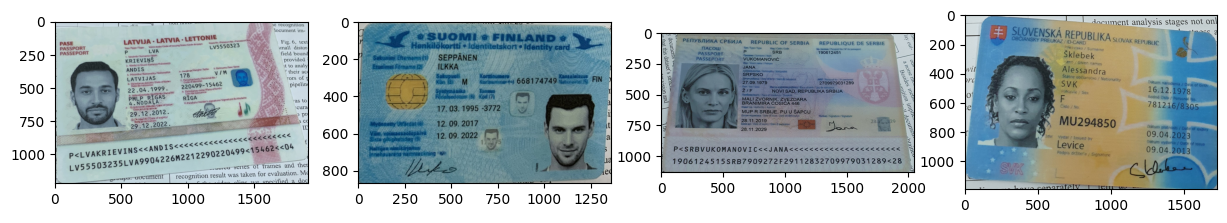

In [14]:
lva_pass = cv2.imread('datasets/cropped/lva_passport/24.jpg')
lva_pass = cv2.cvtColor(lva_pass, cv2.COLOR_BGR2RGB)
fin_id = cv2.imread('datasets/cropped/fin_id/22.jpg')
fin_id = cv2.cvtColor(fin_id, cv2.COLOR_BGR2RGB)
arb_pass = cv2.imread('datasets/cropped/srb_passport/28.jpg')
arb_pass = cv2.cvtColor(arb_pass, cv2.COLOR_BGR2RGB)
svk_id = cv2.imread('datasets/cropped/svk_id/27.jpg')
svk_id = cv2.cvtColor(svk_id, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(15,10))
cols = 4

fig.add_subplot(1, cols, 1)
plt.imshow(lva_pass)
fig.add_subplot(1, cols, 2)
plt.imshow(fin_id)
fig.add_subplot(1, cols, 3)
plt.imshow(arb_pass)
fig.add_subplot(1, cols, 4)
plt.imshow(svk_id)
plt.show()

From a visual inspection, the crops are extremely tight. To utilize a CNN model to detect edges, it would be useful to add padding to the images. 

In [15]:
# Updating the Dataset to add padding 
class ImageDatasetPadded(Dataset):
    def __init__(self, dir, width, height, is_bw=False):
        self.dir = dir
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((width, height)),
            transforms.Pad(30),
            transforms.ToTensor()
        ]) if is_bw else transforms.Compose([
            transforms.Resize((width, height)),
            transforms.Pad(30),
            transforms.ToTensor()
        ])
        self.target_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
        self.imageNames = glob.glob(f'{dir}/*/images/*.jpg')
        self.labelNames = glob.glob(f'{dir}/*/labels/*.txt')
    
    def __len__(self):
        return len(self.imageNames)
    
    def __getitem__(self, index):
        image = Image.open(self.imageNames[index])
        with open(self.labelNames[index], 'r') as file:
            label = file.read()
            label = np.array(label)
        
        return self.transform(image), int(label)

### Retraining with Cropped Images

Step 1 - Creating a sample set using the random_sample function

In [29]:
random_sample('./datasets/cropped', 'datasets/cropped')

./datasets/cropped\alb_id
./datasets/cropped\aze_passport
./datasets/cropped\esp_id
./datasets/cropped\est_id
./datasets/cropped\fin_id
./datasets/cropped\grc_passport
./datasets/cropped\lva_passport
./datasets/cropped\rus_internalpassport
./datasets/cropped\srb_passport
./datasets/cropped\svk_id


Step 2 - Train the model

In [30]:
!python train_cropped.py

Epoch 0: model accuracy 10.00%
Epoch 1: model accuracy 12.40%
Epoch 2: model accuracy 14.00%
Epoch 3: model accuracy 24.40%
Epoch 4: model accuracy 32.40%
Epoch 5: model accuracy 45.20%
Epoch 6: model accuracy 42.80%
Epoch 7: model accuracy 50.40%
Epoch 8: model accuracy 46.00%
Epoch 9: model accuracy 63.60%
Epoch 10: model accuracy 66.80%
Epoch 11: model accuracy 77.20%
Epoch 12: model accuracy 76.00%
Epoch 13: model accuracy 77.60%
Epoch 14: model accuracy 77.20%
Epoch 15: model accuracy 52.80%
Epoch 16: model accuracy 72.00%
Epoch 17: model accuracy 80.00%
Epoch 18: model accuracy 80.00%
Epoch 19: model accuracy 69.60%



Epoch 0: 100%|##########| 100/100 [02:14<00:00,  1.35s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.61it/s]

Epoch 1: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.83it/s]

Epoch 2: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.97it/s]

Epoch 3: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.87it/s]

Epoch 4: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.91it/s]

Epoch 5: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.94it/s]

Epoch 6: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.92it/s]

Epoch 7: 100%|##########| 100/100 [02:50<00:00,  1.71s/it]

Validating: 100%|##########| 50/50 [00:08<00:00,  5.92it/s]

Epoch 8: 100%|##########| 100/1

Step 3 - Test the model

In [31]:
!python test_model.py --model_path "models/cropped_best_model.pth"  --data_path "datasets/cropped" --pad true

Model accuracy 72.00%


### Results
Immediately an improvement in the accuracy of the model is observed. An increase of ~50 percent points on the same dataset. 



## Text Features Classification

While the CNN model above focuses on the visual features present on the identity document, the text features present on the document are completely ignored. 

Extracting text features from a document consists of 2 crucial steps,
- OCR data from the document.
- Clean, normalise and feature engineer the raw OCR data.

For the purposes of this case study, the third part service offered by Azure will be utilized for OCR. 

Pre-extracted raw ocr data for the cropped versions of the identity documents are stored in the `ocr_data.csv` file. Below is a snapshot

In [32]:
ocr_data = pd.read_csv('csv/ocr.csv')
ocr_data.head()

,class,image,text
0,alb_id,00.jpg,LETERNJOFTIM ID\nREPUBLIKA E SHQIPERISE REPUBL...
1,alb_id,01.jpg,LETERNIOFTIL ID\nREPUBLIKA E SHQIPÊRISÉ REPUBL...
2,alb_id,02.jpg,LETERNIOFTIM ID\nREPUBLIKA E SHOIPERISE P\nAhm...
3,alb_id,03.jpg,LETERNJOFTIM ID\nREPUBLIKA E SHQIPÈRISE REPUBL...
4,alb_id,04.jpg,LETFANJOFTIM ID\nREPUBLIKA E SHOIPÊRISE REPUBL...


### Cleaning and Feature Engineering

The following steps are applied to enrich the data,
- Correct recurring OCR errors with a fixed text feature.
- Replace unique features with document type

The following cleaning steps are applied
- Join seperate lines of text into a single line.
- Remove symbols and special characters while retaining accented characters.

In [33]:
FEATURES = {
    'SHQIPERISE': 'ALBANIA',
    'SHQIPÈRISE': 'ALBANIA',
    'SHOIPÊRISE': 'ALBANIA',
    'SHOIPÊRISÉ': 'ALBANIA',
    'SHQIPÊRISÉ': 'ALBANIA',
    'SHOIPÉRISÉ': 'ALBANIA',
    'SHOIPERISÉ': 'ALBANIA',
    'SHQIPËRISE': 'ALBANIA',
    '<': 'PASSPORT',
    'LETERNJOFTIM': 'IDENTITY',
    'LETERNIOFTIL': 'IDENTITY',
    'LETERNIOFTIM': 'IDENTITY',
    'NACIONALDE': 'NACIONAL DE',
    'DEIDENTIDAD': 'DE IDENTIDAD',
}

LABELS_DICT = {
    'alb_id':0,
    'aze_passport':1,
    'esp_id':2,
    'est_id':3,
    'fin_id':4,
    'grc_passport':5,
    'lva_passport':6,
    'rus_internalpassport':7,
    'srb_passport':8,
    'svk_id':9,
}

for idx, row in ocr_data.iterrows():
    for feature in FEATURES:
        # Replace the potentially incorrect ocr text with the correct feature
        # Replace < with PASSPORT 
        ocr_data.at[idx, 'text'] = ocr_data.at[idx, 'text'].replace(feature, FEATURES[feature])

        # Remove special characters and numbers but retain accented characters
        ocr_data.at[idx, 'text'] = re.sub(r"[-!$%^&*()_+|~=`{}\[\]:\";'<>?,.\/0-9]", ' ', ocr_data.at[idx, 'text'])
        
        # Combine ocr in a single line
        ocr_data.at[idx, 'text'] = " ".join(ocr_data.at[idx, 'text'].split('\n'))
    
    # Set the label for the ocr text
    ocr_data.at[idx, 'label'] = LABELS_DICT[ocr_data.at[idx, 'class']]
ocr_data.to_csv('csv/ocr_cleaned.csv')

This cleaned OCR data is now ready to be converted into vectors for classification. 

This Case Study utilizes a Logistic Regression model to simplify interpretation of results.

In [34]:
cleaned_data = ocr_data
x_train, x_test, y_train, y_test = train_test_split(cleaned_data['text'], cleaned_data['label'], test_size=0.4, random_state=42)

# Limiting number of features to 25 to prevent overfitting
# Stripping accents and converting to lowercase to normalise data
vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, max_features=25)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

model = LogisticRegression(max_iter=1000)
model = model.fit(x_train, y_train)

In [35]:
y_pred = model.predict(x_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy Score: 0.98
Confusion Matrix: 
[[41  0  0  0  0  0  0  0  0  3]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  0  0  0  0  1]
 [ 0  0  0  0 37  0  0  2  0  0]
 [ 0  0  0  0  0 46  0  0  0  0]
 [ 0  0  0  0  0  0 33  0  0  0]
 [ 0  0  1  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  1  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 43]]


In [36]:
# Saving models
with open('models/logistic_model.pkl', 'wb') as model_file:
        pickle.dump(model, model_file)

with open('models/vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

### Text Features Results

The text features model performs remarkably well with an accuracy of 98%.

## Fusion Models

An ideal model should be combine the text features present on the document as well the visual features. 

The CNN model chosen in the above steps uses a LogSoftMax activation function. This results in outputs which can be interpreted as probaility of whether the image belongs to a class. 

Likewise, a logistic regression model outputs a probability value of whetehr the image belongs to a class. 

Hence, the two probability scores can be combined to form a fusion ensemble model. 

$$ y = argmax(\alpha [P(y=0/tf),P(y=1/tf),...,P(y=9/tf)] + \beta [P(y=0/vf),P(y=1/vf),...,P(y=9/vf)])$$

Where,
$y$ = Predicted class as per the fusion model  
$P(y=\{i\}/tf) $ = Probability of y classified as class i as per text features model  
$P(y=\{i\}/vf) $ = Probability of y classified as class i as per visual features model  
$\alpha$ = Weightage assigned to text features model outputs  
$\beta$ = Weightage assigned to visual features model outputs  

In [37]:
!python fusion_model.py

C:\Users\soham\Downloads\Case Study\fusion_model.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd

100%|##########| 250/250 [00:11<00:00, 22.30it/s]


The output of the above script is a csv file containing
- Actual Class
- Predicted class as per Text Features
- Probability of predicted class
- Probability of all classes as predicted by text features
- Predicted class as per Visual Features
- Probability of predicted class
- Probability of all classes as predicted by visual features
- Predicted class as per a fusion model with an average of probability from text and visual features
- Probability of predicted class
- Probability of all classes as predicted by fusion

In [38]:
fusion_results = pd.read_csv('csv/results_fusion.csv')
fusion_results.head()

,actual_class,tf_predicted_class,tf_predicted_prob,tf_match,tf_predicted_features,cnn_predicted_class,cnn_predicted_prob,cnn_match,cnn_predicted_features,fusion_predicted_class,fusion_predicted_prob,fusion_match
0,0,0.0,0.718575,1,"[0.7185751050841291, 0.04216188872401173, 0.00...",0,1.000000,1,"[1.0, 1.7161817314079423e-19, 1.82354413687246...",0,0.859288,1
1,0,0.0,0.794785,1,"[0.794785431768409, 0.03351695722728846, 0.003...",0,0.999989,1,"[0.9999890327453613, 1.1673871938566727e-11, 6...",0,0.897387,1
2,0,0.0,0.800733,1,"[0.8007330279681967, 0.03509246750337732, 0.00...",0,0.997567,1,"[0.9975674152374268, 6.861218480480602e-06, 0....",0,0.899150,1
3,0,0.0,0.638457,1,"[0.6384571313021484, 0.05405814310390209, 0.00...",0,0.945844,1,"[0.945843517780304, 0.0008159882272593677, 0.0...",0,0.792150,1
4,0,0.0,0.868695,1,"[0.868695214994677, 0.014581616121069776, 0.00...",0,0.953407,1,"[0.953407347202301, 0.0002954614465124905, 0.0...",0,0.911051,1


The Ideal weightage $\alpha$ and $\beta$ for this fusion model can be determined by plotting a Precision vs Recall curve using the weight split instead of threshold.

In [39]:
def plot_pr(split):
    for idx, row in fusion_results.iterrows():
        actual_class = row['actual_class']
        tf_probabilities = np.array(json.loads(row['tf_predicted_features']))
        vf_probabilities = np.array(json.loads(row['cnn_predicted_features']))
        fusion_probabilites = (split)*tf_probabilities + (1-split)*vf_probabilities
        fusion_predicted_class = fusion_probabilites.argmax()
        fusion_predicted_probability = fusion_probabilites[fusion_predicted_class]
        fusion_results.at[idx, 'fusion_predicted_class'] = fusion_predicted_class
        fusion_results.at[idx, 'fusion_predicted_probability'] = fusion_predicted_probability
        fusion_results.at[idx, 'fusion_probabilities'] = json.dumps(fusion_probabilites.tolist())
    
    LABELS_DICT = {
        0: 'alb_id',
        1: 'aze_passport',
        2: 'esp_id',
        3: 'est_id',
        4: 'fin_id',
        5: 'grc_passport',
        6: 'lva_passport',
        7: 'rus_internalpassport',
        8: 'srb_passport',
        9: 'svk_id',
    }
    fig = plt.figure(figsize=(5, 5))
    classes = fusion_results['actual_class'].unique()
    plotted_threshold = []
    for c in classes:
        y_true = fusion_results['actual_class'] == c
        y_true = y_true.astype(int)
        y_pred = fusion_results['fusion_predicted_class'] == c
        y_pred = y_pred.astype(int)
        y_score = fusion_results['fusion_probabilities']
        y_score = [json.loads(x)[c] for x in y_score]
        true_positives = len(fusion_results[(fusion_results['actual_class'] == c) & (fusion_results['fusion_predicted_class'] == c)])
        false_positives = len(fusion_results[(fusion_results['actual_class'] != c) & (fusion_results['fusion_predicted_class'] == c)])
        true_negatives = len(fusion_results[(fusion_results['actual_class'] != c) & (fusion_results['fusion_predicted_class'] != c)])
        false_negatives = len(fusion_results[(fusion_results['actual_class'] == c) & (fusion_results['fusion_predicted_class'] != c)])
    
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        precision, recall, thresholds = precision_recall_curve(y_true, y_score, drop_intermediate=True)
        
        plt.plot(recall,precision, label=f'{LABELS_DICT[c]}')       
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.title(f'PR Curve for {int(split*100)}:{int((1-split)*100)}')
        plt.legend()
    plt.show()

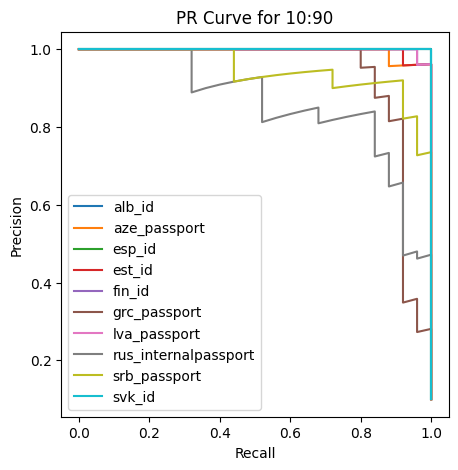

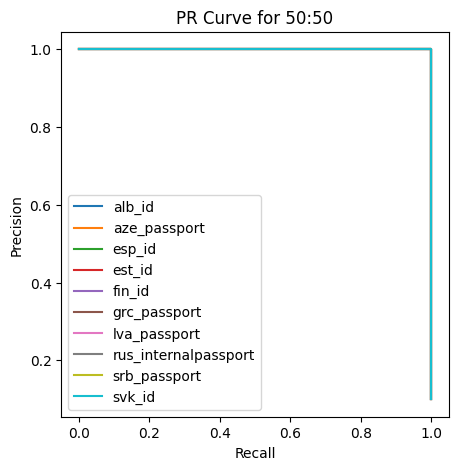

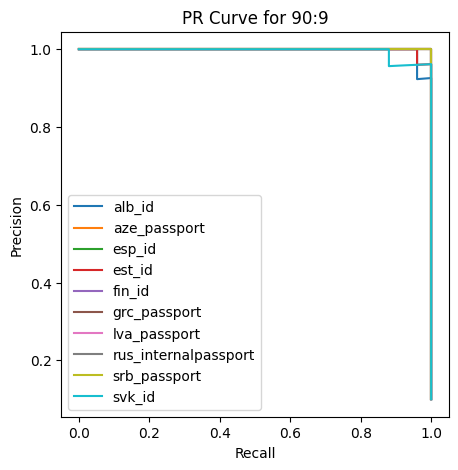

In [40]:
plot_pr(0.1)
plot_pr(0.5)
plot_pr(0.9)

A split of 50:50 gives near perfect recall and precision at certain thresholds. Determining this threshold should help finalise the weights to be used for this fusion model.

The ideal model will depend on the busines usecase depending on the priority assinged to Precion or Recall.

## Functions in this Directory

`model.py` - Convolution model and data loaders.  
`random_sample.py` - Create a random sample from the dataset.  
`train_baseline.py` - Train baseline convolution model.  
`train_card.py` - Train yolov8 model.  
`train_cropped.py` - Train convolution model on cropped images.  
`train_text_features.py` - Clean text features and train machine learning model.  
`crop_cards.py` - Utilize the trained yolov8 model to crop cards form dataset.  
`fusion_model.py` - Create a fusion model from cnn and text features model.  
`test_model.py` - Test baseline and crop models using data loaders.  
`test_single.py` - Test baseline or crop model on a single input image.  
